# Infer ***nucleus*** and the ***cell mask*** -  2️⃣, 3️⃣

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #2 ***nucleus*** and #3 ***cell mask*** from the inverse of ***cytoplasm*** in order to understand the organelle interactome  

Dependencies:
1. The ***nucleus*** and ***cell mask*** inference rely on the ***cytoplasm_from_composite*** inference.  Therefore all of the sub-cellular objects rely on the cytoplasm segmentation.
2. Only one cell is in the field of view.


> CONVENTION:  "nuclei" for the segmentation of ALL nuclei in the image.  "nucleus" for the ***single*** cellmask-masked version.




### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from aicssegmentation.core.pre_processing_utils import  intensity_normalization, image_smoothing_gaussian_slice_by_slice 
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label
import skimage
import tifffile


# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.core.file_io import (read_czi_image,
                                        list_image_files, 
                                        import_inferred_organelle)
from infer_subc_2d.core.img import *
import infer_subc_2d.organelles
       

%load_ext autoreload
%autoreload 2

In [ ]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )                       


## SETUP


CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.


In [ ]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [ ]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']



### Get and load Image for processing - specifically for __pre-processed__ images

> #### Preprocessing:
> In this instance, we are using [Huygens Essential Software](https://svi.nl/Homepage) to deconvolve 3D fluorescence confocal images. The output is an OME TIFF file which contains the z-slices and channels in axis 0 (channel 0, zslice 1-40, channel 1, etc. etc.).

An OME TIFF reads in as a dask array (similar to a numpy array, but has a slightly different format)

In [2]:
# this will be the example for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Documents\Python Scripts\Infer-subc-2D"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "neuron_raw_OME"
im_type = ".tiff"

# get the list of all files in "raw"
img_file_list = list_image_files(data_path,im_type)
# test_img_name = img_file_list[test_img_n]
# test_img_name

img_file_list

['C:\\Users\\Shannon\\Documents\\Python Scripts\\Infer-subc-2D\\neuron_raw_OME\\20221027_C2-107_well_1_cell_1_untreated_Linear_unmixing_decon.ome.tiff']

In [3]:
#select one image
test_img = img_file_list[0]

# isolate image as an ndarray and metadata as a dictionary
img_data, meta_dict = read_czi_image(test_img)

# # get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
huygens_meta = meta_dict['metadata']['raw_image_metadata']
file_name = meta_dict['file_name'].split('\\')[-1][:-9]

c:\Users\Shannon\Anaconda3\envs\infer-subc-2D\lib\site-packages\ome_types\_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## infer ***nucleus*** and ***cell mask***


### INPUT

In [5]:
###################
# INPUT
###################
seg_path = data_root_path / "neuron_raw_OME_segmentation"
cytoplasm_filename = file_name + "_cytoplasm.tiff"
cytoplasm_filename_path = seg_path / cytoplasm_filename
cytoplasm_mask = tifffile.imread(cytoplasm_filename_path)

### PRE-PROCESSING


In [8]:
###################
# PRE_PROCESSING
###################           
cytoplasm_dilated = skimage.morphology.binary_dilation(cytoplasm_mask)

### CORE PROCESSING

In [14]:
###################
# CORE_PROCESSING
###################
# Cell mask
cell_hole_min = 0
cell_hole_max = 500
cell_small_object_width = 0
cell_method = '3D'
cell_connectivity = 1
cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, hole_min=cell_hole_min, hole_max=cell_hole_max, min_size=cell_small_object_width, method=cell_method)
cytoplasm_eroded = skimage.morphology.binary_erosion(cytoplasm_filled)

cell_bw = cytoplasm_eroded

# Nucleus
nuclei_xor = np.logical_xor(cytoplasm_mask, cell_bw)

### POST PROCESSING

In [17]:
###################
# POST_PROCESSING
###################
# Nucleus
nuc_hole_min = 0
nuc_hole_max = 0
nuc_small_object_width = 20
nuc_method = '3D'
nuc_connectivity = 3
nuc_cleaned_img = fill_and_filter_linear_size(nuclei_xor, hole_min=nuc_hole_min, hole_max=nuc_hole_max, min_size=nuc_small_object_width, method=nuc_method, connectivity=nuc_connectivity)

# Cell mask
extra_from_dilate = np.logical_xor(nuc_cleaned_img, nuclei_xor)
cell_mask_cleaned_img = np.logical_xor(cell_bw, extra_from_dilate)

### Renaming

In [19]:
cell_mask = cell_mask_cleaned_img.astype(dtype=int)
nucleus_mask = nuc_cleaned_img.astype(dtype=int)

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [44]:
viewer = napari.Viewer()

28-Mar-23 12:37:03 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x691+1890-120 (frame: 1106x730+1882-151) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY2". Resulting geometry: 870x587+1889-127 (frame: 886x626+1881-158) margins: 8, 31, 8, 8 minimum size: 612x587 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=628,626 maxtrack=0,0)


In [45]:
viewer.add_image(img_data, scale=scale)
viewer.add_image(cytoplasm_mask, scale=scale, opacity=0.25, colormap='magenta')
viewer.add_image(nucleus_mask, scale=scale, opacity=0.25, colormap='blue')
viewer.add_image(cell_mask, scale=scale, opacity=0.25, colormap='green')

<Image layer 'cell_mask' at 0x274d4c04d60>

## SAVE inferred nuclei to .tif file

In [ ]:


# out_file_n = export_inferred_organelle(nuclei_object, "nuclei", meta_dict, out_data_path)


## DEFINE `_infer_nuclei_fromlabel` function

Based on the _prototyping_ above define the function to infer nuclei.  


In [30]:
##########################
#  _infer_nuclei
##########################
def _infer_nucleus_cellmask_from_cytoplasm(cytoplasm_mask: np.ndarray,
                                            cell_holefill_min: int,
                                            cell_holefill_max: int,
                                            cell_small_object_width: int,
                                            cell_method: str,
                                            cell_connectivity: int,
                                            nuc_holefill_min: int,
                                            nuc_holefill_max: int,
                                            nuc_small_object_width: int,
                                            nuc_method: str,
                                            nuc_connectivity: int
                                                            ) -> np.ndarray:
    """
    Procedure to infer the nucleus and cell masks from the cytoplasm mask (cell area without nuclei). 
    This could be used in the case where the nuclei are not stained and other organelle markers fill the cytoplasm, but not the nuclear space.

    Parameters
    ------------
    cytoplasm_mask: np.ndarray
        3D (XYZ) binary mask of cytoplasm (whole cell area without the nucleus)
    cell_holefill_min: int
        minimum size of holes to fill (in 1D length) for cell mask
    cell_holefill_max: int
        maximum size of holes to fill (in 1D length) for cell mask
    cell_small_object_width: int
        maximum size of small object to remove (in 1D length) for cell mask
    cell_method: str
        '3D' or 'slice-by-slice' for size filtering and hole filling for cell mask
    cell_connectivity: int
        connectivity to use when computing size filter for cell mask
    nuc_holefill_min: int
        minimum size of holes to fill (in 1D length) for nucleus mask
    nuc_holefill_max: int
        maximum size of holes to fill (in 1D length) for nucleus mask
    nuc_small_object_width: int
        maximum size of small object to remove (in 1D length) for nucleus mask
    nuc_method: str
        '3D' or 'slice-by-slice' for size filtering and hole filling for cell mask
    nuc_connectivity: int
        connectivity to use when computing size filter for nucleus mask


    Returns
    -------------
    cell_mask
        mask defining extent of the entire cell
    nucleus_mask
        mask defining extent of the nucleus

    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    cytoplasm_dilated = skimage.morphology.binary_dilation(cytoplasm_mask)


    ###################
    # CORE_PROCESSING
    ###################
    # Cell mask
    cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, hole_min=cell_holefill_min, hole_max=cell_holefill_max, min_size=cell_small_object_width, method=cell_method, connectivity=cell_connectivity)
    cytoplasm_eroded = skimage.morphology.binary_erosion(cytoplasm_filled)

    cell_bw = cytoplasm_eroded

    # Nucleus
    nuclei_xor = np.logical_xor(cytoplasm_mask, cell_bw)


    ###################
    # POST_PROCESSING
    ###################
    # Nucleus
    nuc_cleaned_img = fill_and_filter_linear_size(nuclei_xor, hole_min=nuc_holefill_min, hole_max=nuc_holefill_max, min_size=nuc_small_object_width, method=nuc_method, connectivity=nuc_connectivity)

    # Cell mask
    extra_from_dilate = np.logical_xor(nuc_cleaned_img, nuclei_xor)
    cell_mask_cleaned_img = np.logical_xor(cell_bw, extra_from_dilate)


    ###################
    # RENAMING
    ###################
    cell_mask = cell_mask_cleaned_img.astype(dtype=int)
    nucleus_mask = nuc_cleaned_img.astype(dtype=int)

    return cell_mask, nucleus_mask


## DEFINE `_fixed_infer_nuclei` function


In [34]:
##########################
#  fixed_infer_nucleus_cellmask_from_cytoplasm
##########################
def _fixed_infer_nucleus_cellmask_from_cytoplasm(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
 
    Returns
    -------------
    nuclei_object
        inferred nuclei
    
    """
    cell_holefill_min = 0
    cell_holefill_max = 500
    cell_small_object_width = 0
    cell_method = '3D'
    cell_connectivity = 3
    nuc_holefill_min = 0
    nuc_holefill_max = 0
    nuc_small_object_width = 20
    nuc_method = '3D'
    nuc_connectivity = 3

    return _infer_nucleus_cellmask_from_cytoplasm(cytoplasm_mask,
                                    cell_holefill_min,
                                    cell_holefill_max,
                                    cell_small_object_width,
                                    cell_method,
                                    cell_connectivity,
                                    nuc_holefill_min,
                                    nuc_holefill_max,
                                    nuc_small_object_width,
                                    nuc_method,
                                    nuc_connectivity)


---------------------
## TEST `_infer_nuclei`  function defined above


In [35]:

_cell_mask, _nucleus_mask =  _fixed_infer_nucleus_cellmask_from_cytoplasm(cytoplasm_mask) 


---------------------
# TEST `infer_nuclei_fromlabel` exported functions

> the prototype `_infer_nuclei` was copied to the [`.organelles.nuclei`](../infer_subc_2d/organelles/nuclei.py) sub-module 
##
`infer_nuclei_fromlabel` procedure

Use the `infer_nuclei_fromlabel` function to infer the Nucleus and export it as an _ome.tif_ for easy reference.

In [42]:
from infer_subc_2d.organelles.nuclei import infer_nucleus_cellmask_from_cytoplasm, fixed_infer_nucleus_cellmask_from_cytoplasm

cell_mask_2, nucleus_mask_2 =  fixed_infer_nucleus_cellmask_from_cytoplasm(cytoplasm_mask) 

## Visualize  2


In [46]:
viewer.add_image(_nucleus_mask, scale=scale, opacity=0.25, colormap='blue')
viewer.add_image(_cell_mask, scale=scale, opacity=0.25, colormap='green')
viewer.add_image(nucleus_mask_2, scale=scale, opacity=0.25, colormap='blue')
viewer.add_image(cell_mask_2, scale=scale, opacity=0.25, colormap='green')

<Image layer 'cell_mask_2' at 0x274d4aa7d00>

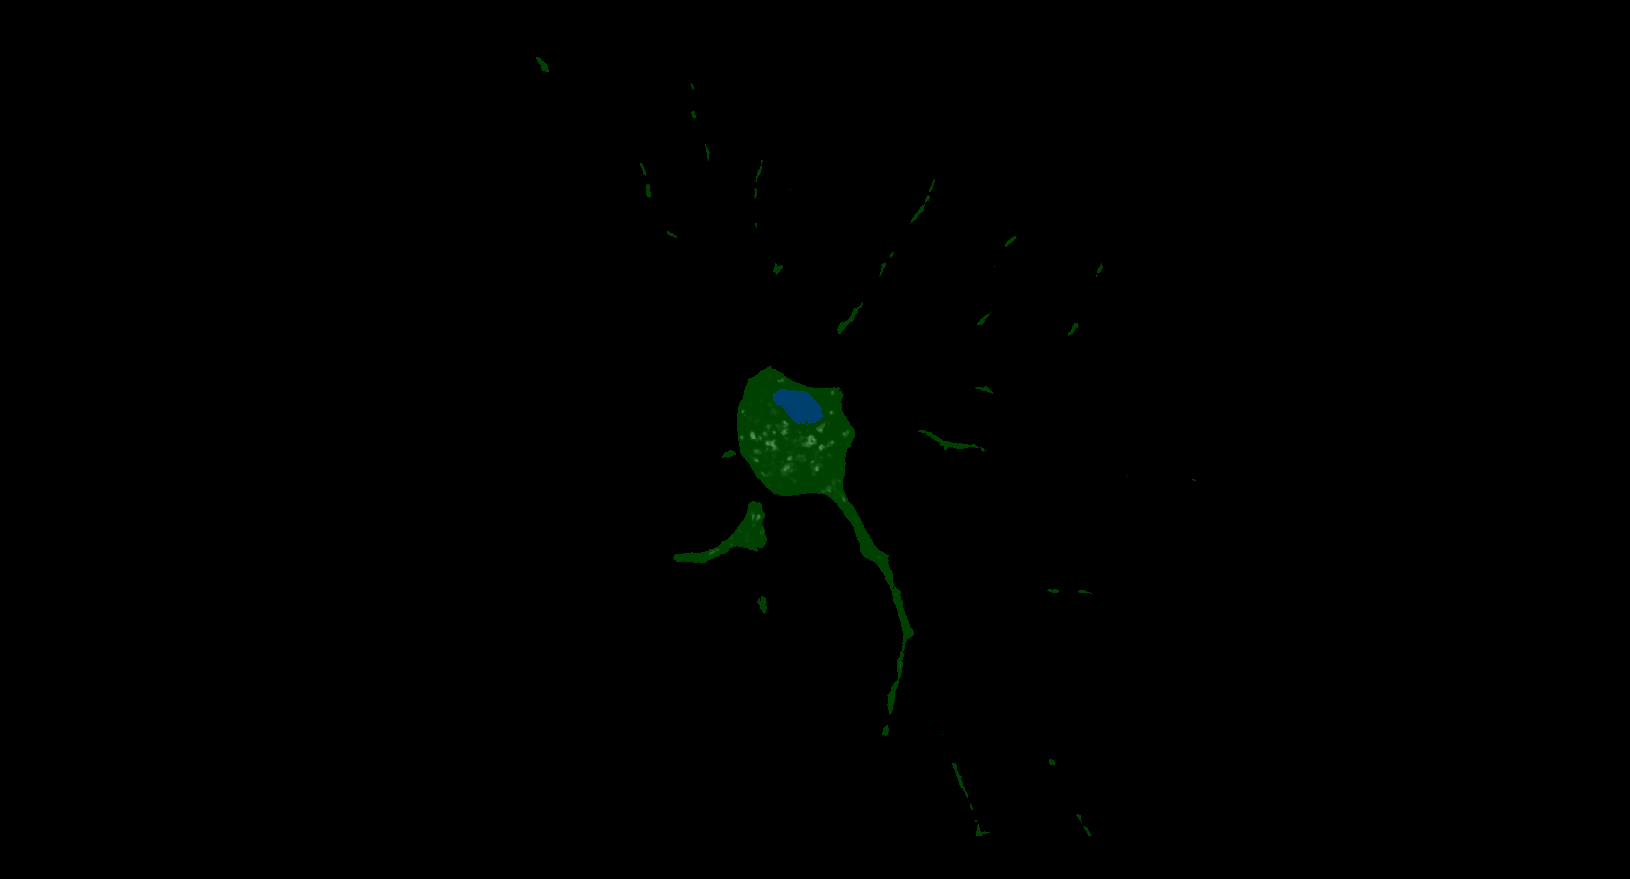

In [47]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [48]:
viewer.close()

-------------
## SUMMARY

The above outlines how the cell and nucleus masks are generated from the cytoplasm mask

### NEXT: INFER LYSOSOMES

proceed to [04_infer_lysosome.ipynb](./04_infer_lysosome.ipynb)
